In [1]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import pandas as pd
import numpy as np
import re

In [33]:
with open("linux_input.txt", "r", errors="ignore") as f:
    text = f.read()
    text = text.lower()
    text = re.sub('["\n\n"]', "   ", text)
    text = re.sub('[^a-z0-9 \.]', '', text)

<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_194670/810601200.py:5: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('[^a-z0-9 \.]', '', text)


In [34]:
text = text.strip()
text = text.split("   ")
text = [i for i in text if i != '']
#print(text[:500])
text = [i.replace(".","") for i in text]

X1, y1 = [],[]
#k,n = 0,0
for i in text:
  cxt = 5
  out = cxt*["."]
  #print(i.strip().split())
  if i.strip().split() != []:
      X1.append(out.copy())
      y1.append(i.strip().split()[0])
      for j in range (len(i.strip().split())-1):
        #print(out[1:4])
        out[0:4] = out[1:5]
        #print(out[0:3])
        out[4] = i.strip().split()[j]
        #print(out[1:4])
        #Why? copy()
        X1.append(out.copy())
        y1.append(i.strip().split()[j+1])


X,X_test,y,y_test = [],[],[],[]
k = 0
for i in range (len(X1)):
  if X1[i] == [".",".",".",".","."]:
    k += 1
  if k < 13600:
    X.append(X1[i])
    y.append(y1[i])
  else:
    X_test.append(X1[i])
    y_test.append(y1[i])


In [35]:
word = sorted(list(set(y1)))

w_ = ["."]
w_.extend(word)

emb_d = 32
emb_l = len(w_)
emb = torch.nn.Embedding(emb_l,emb_d)

In [36]:
class nxt_word(nn.Module):
  def __init__(self, cxt, emb_l, emb_d, size):
    super().__init__()
    self.emb = nn.Embedding(emb_l, emb_d)
    self.lin1 = nn.Linear(cxt * emb_d, size)
    self.lin2 = nn.Linear(size, emb_l)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.relu(self.lin1(x))
    x = self.lin2(x)
    return x

In [37]:
def train_model(model, X, Y,X_test, y_test, epochs=500, batch_size=30, lr=1e-3, wd=1e-2, print_every=50):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()

    losses, times, loss_ = [], [], []
    for epoch in range(epochs):
        start = time.time()
        total_loss, n_batches = 0, 0

        for i in range(0, len(X), batch_size):
            x_batch = X[i:i+batch_size]
            y_batch = Y[i:i+batch_size]

            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            n_batches += 1
  #      model.eval()
  #      with torch.no_grad():
  #        y_pred = model(X_test)
  #        loss_val = loss_fn(y_pred, y_test).item()
  #        loss_.appned(loss_val)
        model.eval()
        val_loss_total, val_batches = 0, 0
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                x_val = X_test[i:i+batch_size]
                y_val = y_test[i:i+batch_size]
    
                logits_val = model(x_val)
                loss_val = loss_fn(logits_val, y_val)
    
                val_loss_total += loss_val.item()
                val_batches += 1

        avg_val_loss = val_loss_total / val_batches
        loss_.append(avg_val_loss)
        model.train() 
        avg_loss = total_loss / n_batches
        losses.append(avg_loss)
        times.append(time.time() - start)

        if epoch % print_every == 0:
            print(f"Epoch {epoch:4d} | Loss: {avg_loss:.4f} | Time: {times[-1]:.2f}s")

    return losses, times, loss_

In [38]:
def generate_name(model, word, inp , max_len=10):
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
 #       context = torch.tensor((5-len(inp))*[0]).to(device)+inp
 #       torch.cat((torch.tensor((5)*[0]).to(device),y_1))
        context = torch.cat((torch.tensor((5-len(inp))*[0]).to(device),inp))
        name = ''
        for i in range(max_len):
            x = torch.tensor(context).view(1, -1).to(device)
            y_pred = model(x)
            ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
            ch = word[ix]
            if ch == '...':
                break
            name += " " + ch
            context = torch.cat((context[1:] , torch.tensor([ix]).to(device)))
    # Set model back to training mode
    model.train()
    return name

In [39]:
stoi = {w:i for i,w in enumerate(w_)}
itos = {i:w for w,i in stoi.items()}

X_ = [[stoi.get(i,0) for i in j] for j in X]
X_ = torch.tensor(X_).to(device)

y_ = [stoi[j] for j in y]
y_ = torch.tensor(y_).to(device)

X_p = [[stoi[i] for i in j] for j in X_test]
X_p = torch.tensor(X_p).to(device)

y_p = [stoi[j] for j in y_test]
y_p = torch.tensor(y_p).to(device)

In [40]:
model = nxt_word(cxt, emb_l, emb_d, size = 1024).to(device)
model = torch.compile(model)

In [41]:
losses, times, loss_ = train_model(model, X_, y_, X_p,y_p,epochs=601, batch_size=4096, lr=0.001, wd=0.01, print_every=25)


Epoch    0 | Loss: 9.7383 | Time: 5.56s
Epoch   25 | Loss: 3.3124 | Time: 3.81s
Epoch   50 | Loss: 2.8197 | Time: 3.64s
Epoch   75 | Loss: 2.6241 | Time: 3.65s
Epoch  100 | Loss: 2.5381 | Time: 3.55s
Epoch  125 | Loss: 2.5005 | Time: 3.48s
Epoch  150 | Loss: 2.4887 | Time: 3.46s
Epoch  175 | Loss: 2.4724 | Time: 3.46s
Epoch  200 | Loss: 2.4657 | Time: 3.52s
Epoch  225 | Loss: 2.4621 | Time: 3.72s
Epoch  250 | Loss: 2.4599 | Time: 3.50s
Epoch  275 | Loss: 2.4561 | Time: 3.50s
Epoch  300 | Loss: 2.4548 | Time: 3.48s
Epoch  325 | Loss: 2.4538 | Time: 3.44s
Epoch  350 | Loss: 2.4512 | Time: 3.44s
Epoch  375 | Loss: 2.4504 | Time: 3.44s
Epoch  400 | Loss: 2.4488 | Time: 3.44s
Epoch  425 | Loss: 2.4478 | Time: 3.46s
Epoch  450 | Loss: 2.4511 | Time: 3.50s
Epoch  475 | Loss: 2.4459 | Time: 3.48s
Epoch  500 | Loss: 2.4445 | Time: 3.44s
Epoch  525 | Loss: 2.4442 | Time: 3.48s
Epoch  550 | Loss: 2.4443 | Time: 3.44s
Epoch  575 | Loss: 2.4423 | Time: 3.44s
Epoch  600 | Loss: 2.4420 | Time: 3.50s


In [42]:
inp = []
n = int(input("Context length:"))
for i in range (n):
  inp.append(str(input()))


y_1 = [stoi[j] for j in inp]
y_1 = torch.tensor(y_1).to(device)


print(generate_name(model, w_,y_1))

Context length: 2
 public
 of


/tmp/ipykernel_194670/3575751382.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(context).view(1, -1).to(device)


 the radix tree gets memzonebmrtree the well is no group


/tmp/ipykernel_194670/3575751382.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(context).view(1, -1).to(device)


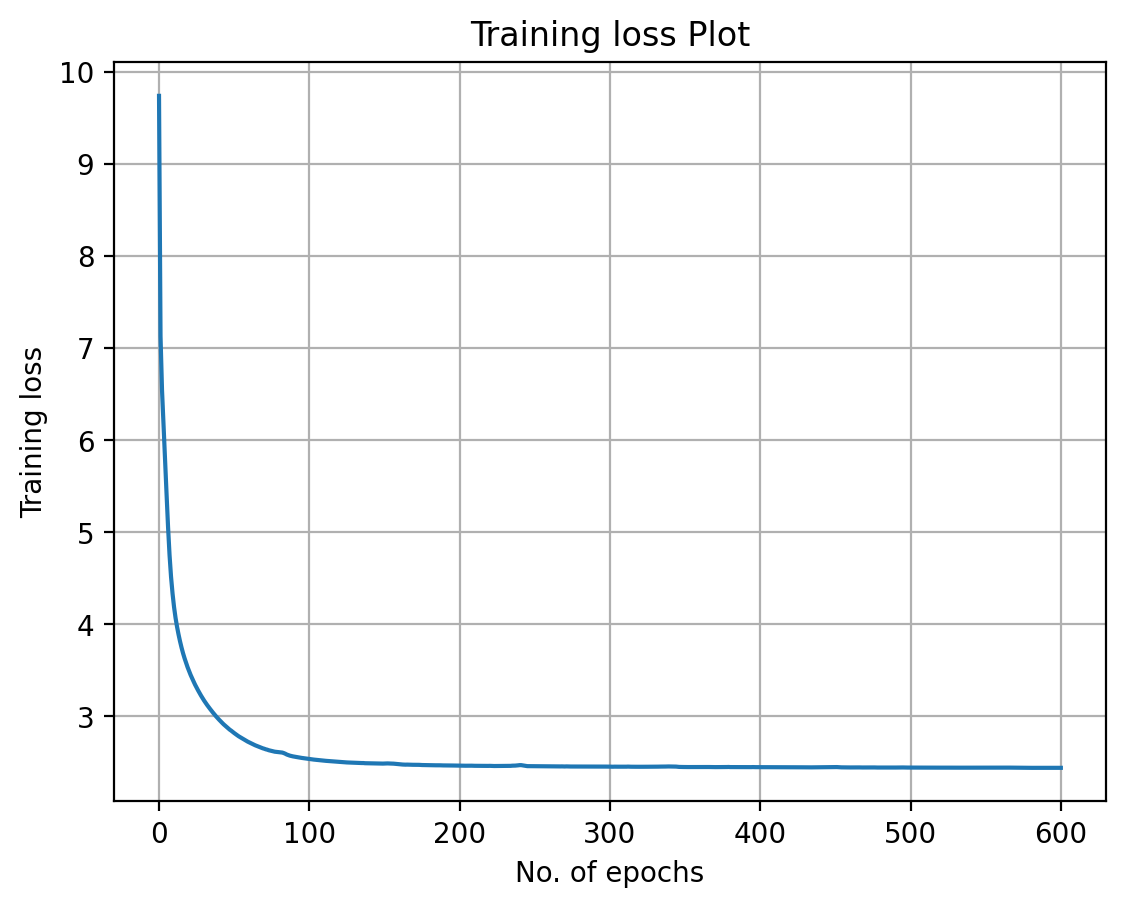

In [43]:
plt.plot(np.arange(601), losses)
plt.xlabel("No. of epochs")
plt.ylabel("Training loss")
plt.title("Training loss Plot")
plt.grid()

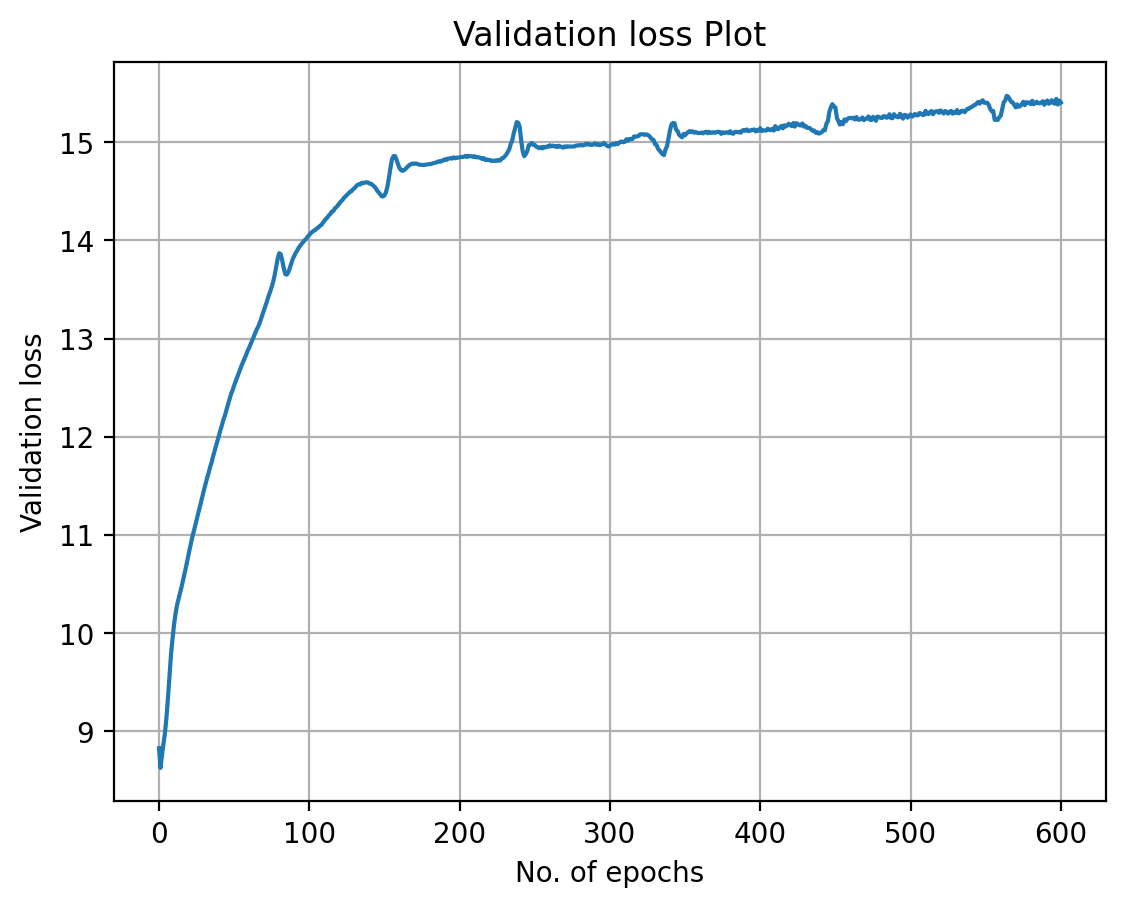

In [44]:
plt.plot(np.arange(601), loss_)
plt.xlabel("No. of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss Plot")
plt.grid()

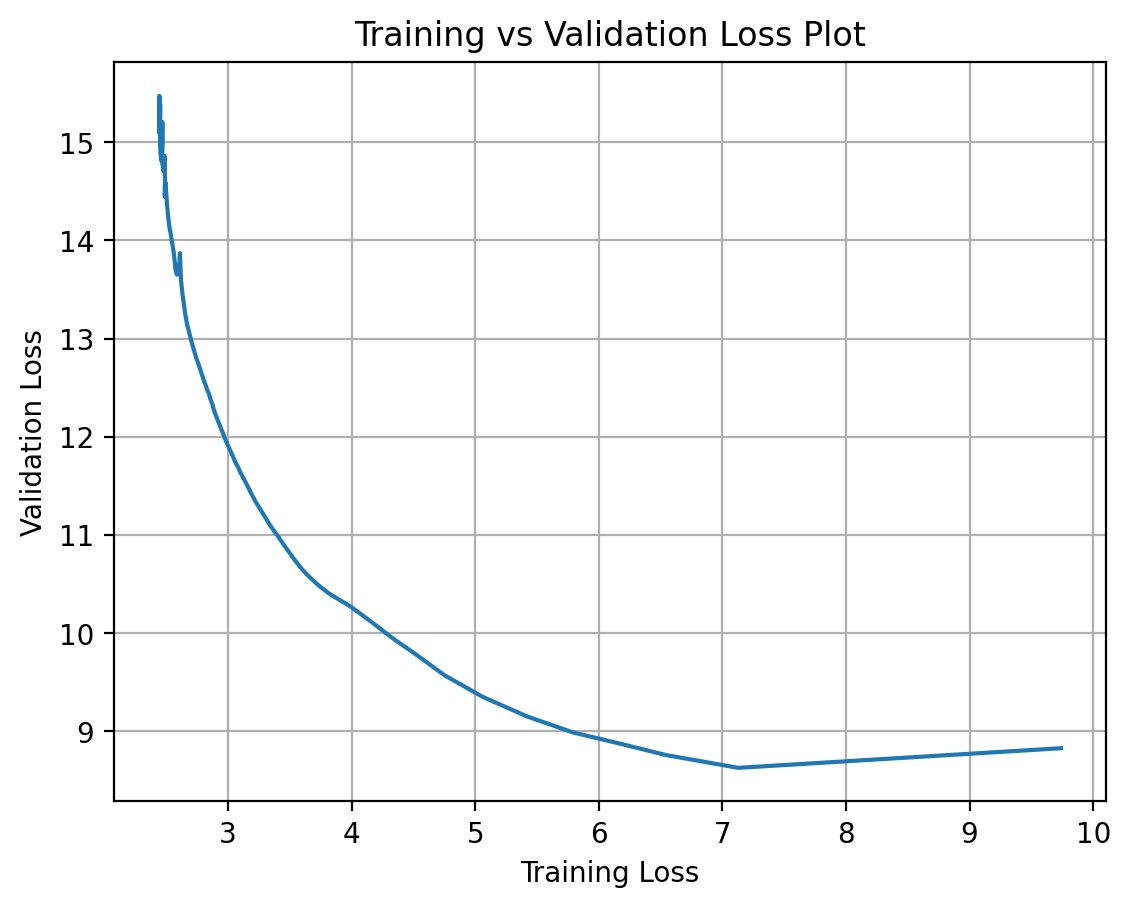

In [45]:
plt.plot(losses, loss_)
plt.xlabel("Training Loss")
plt.ylabel("Validation Loss")
plt.title("Training vs Validation Loss Plot")
plt.grid()

In [46]:
print(f"The final validation loss is : {loss_[-1]}")

The final validation loss is : 15.402742743492126


In [47]:
print(f"Vocabulary size is: {len(y1)}")

Vocabulary size is: 604558


In [49]:
from collections import Counter
d_1 = Counter(y1)

srt_d = sorted(d_1.items(), key=lambda item: item[1], reverse=True)
srt_d = dict(srt_d)

print(f"The ten most frequently occuring words are : {list(srt_d.keys())[:10]}")

print(f"The ten least frequently occuring words are : {list(srt_d.keys())[-10:-1]}")

The ten most frequently occuring words are : ['if', 'the', 'return', 'struct', 'int', 'to', '0', 'static', 'void', 'is']
The ten least frequently occuring words are : ['contexttrackingexitcontextuser', 'nokprobesymbolcontexttrackinguserexit', 'contexttrackingtaskswitch', 'userkernel', 'tif', 'contexttrackingtaskswitchstruct', 'cleartskthreadflagprev', 'settskthreadflagnext', 'configcontexttrackingforce']


In [50]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

In [52]:
dta = pd.DataFrame(emb.weight.detach().numpy())
dta["Lbl"] = np.arange(len(w_))
dta.columns = dta.columns.astype(str)
dta

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,Lbl
0,-1.235850,-0.944101,-0.679764,-0.561368,-0.680854,0.777346,0.867488,0.927005,-0.790397,-0.251100,...,1.919928,1.197501,0.558397,0.858671,-0.636115,0.972074,-0.386203,0.929920,1.164911,0
1,0.889327,1.106200,0.185101,-0.034816,1.159868,-0.250569,-0.467806,0.350634,-0.056770,1.173819,...,0.276029,1.108856,0.340762,0.252674,0.268487,0.688414,1.034995,0.166534,1.019923,1
2,-0.403208,0.250363,-0.666387,0.770279,-0.206094,-0.470445,-1.493485,0.281462,-2.245033,0.800435,...,-0.710571,1.048047,0.661311,-0.110005,0.015272,1.477767,-0.793107,-0.169217,0.946003,2
3,0.180478,2.378638,-0.946284,-0.797202,-0.544292,-1.013188,-0.714773,1.508327,1.186030,-0.503801,...,0.702944,1.841064,0.862170,-1.846364,-0.474036,-0.805988,0.229105,-0.428108,-0.719750,3
4,-0.732710,0.318704,-0.130535,-0.418271,0.912602,-1.610589,-0.783072,-1.934779,0.024770,-0.601225,...,0.586240,-0.991248,-0.420206,-0.687685,-0.094958,1.308446,-0.749705,-0.389030,-0.697497,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69103,-1.026929,-1.372411,0.009495,1.373987,-0.743760,-0.988556,1.693599,0.324222,1.578542,-0.202630,...,0.938207,0.287517,-1.161935,0.299969,-0.417292,-0.065510,-0.379778,-0.021559,0.282249,69103
69104,0.149123,0.522562,-0.830175,-0.549805,-0.289109,0.465672,0.364770,0.877110,-0.602592,-1.056301,...,-0.384756,-0.635679,-0.177031,0.129447,1.400876,-0.612003,0.560808,-0.063116,0.120650,69104
69105,0.679321,-0.102655,-0.324761,-1.510710,0.469659,-1.790532,-0.438723,-2.426249,-0.149688,0.310943,...,-1.096628,1.084416,1.414455,-0.020986,0.234615,0.636382,0.360889,0.240878,-0.118687,69105
69106,-0.381726,-0.283269,-1.250577,-0.545856,1.250902,0.639081,-0.441844,0.578308,0.425232,-0.300508,...,0.662032,0.340610,0.982686,-0.001804,-1.345867,-0.115253,-0.951891,-0.185764,-1.114604,69106


In [ ]:
s_dta = StandardScaler().fit_transform(dta)

mdl = TSNE(n_components = 2, random_state = 42)
tsne_dta = mdl.fit_transform(s_dta)
tsne_dta = np.vstack([tsne_dta.T, w_]).T
tsne_df = pd.DataFrame(tsne_dta, columns = ["1","2","Label"])

colors = plt.cm.tab10.colors
clr_map = {label: colors[i % len(colors)] for i, label in enumerate(w_)}
clrs = [clr_map[l] for l in w_]
plt.scatter(tsne_df["1"], tsne_df["2"], color = clrs)
plt.show()